In [1]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook

# import lightgbm as lgb
# import xgboost as xgb
#from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

#import altair as alt
#from altair.vega import v5
from IPython.display import HTML

In [ ]:
# import pkg_resources
# installed_packages = pkg_resources.working_set
# installed_packages_list = sorted(["%s==%s" % (package.key, package.version) for package in installed_packages])
# print(installed_packages_list)

# import pip
# from subprocess import call
# for package in installed_packages_list:
#     print("pip install --upgrade " + package[:package.find("==")])
#     call("pip install --upgrade " + package[:package.find("==")], shell=True)

['absl-py==0.5.0', 'alabaster==0.7.10', 'anaconda-client==1.6.3', 'anaconda-navigator==1.6.2', 'anaconda-project==0.6.0', 'asn1crypto==0.22.0', 'astor==0.7.1', 'astroid==1.4.9', 'astropy==1.3.2', 'babel==2.4.0', 'backports.shutil-get-terminal-size==1.0.0', 'beautifulsoup4==4.6.0', 'bitarray==0.8.1', 'blaze==0.10.1', 'bleach==1.5.0', 'bokeh==0.12.5', 'boto==2.46.1', 'bottleneck==1.2.1', 'bz2file==0.98', 'catplot==1.3.3', 'cffi==1.10.0', 'chardet==3.0.3', 'click==6.7', 'cloudpickle==0.2.2', 'clyent==1.2.2', 'colorama==0.3.9', 'comtypes==1.1.2', 'conda==4.5.11', 'contextlib2==0.5.5', 'cryptography==1.8.1', 'cssselect==1.0.1', 'cycler==0.10.0', 'cython==0.25.2', 'cytoolz==0.8.2', 'dask==0.19.4', 'datashape==0.5.4', 'decorator==4.0.11', 'distributed==1.16.3', 'docutils==0.13.1', 'entrypoints==0.2.2', 'enum34==1.1.6', 'et-xmlfile==1.0.1', 'fastcache==1.0.2', 'flask-cors==3.0.2', 'flask==0.12.2', 'gast==0.2.0', 'gensim==3.5.0', 'gevent==1.2.1', 'greenlet==0.4.12', 'grpcio==1.15.0', 'h5py==2.8

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = pd.read_csv('C:/Users/MJ/Desktop/compas/PJT002_train.csv', encoding = 'UTF-8')
# test = pd.read_csv('C:/Users/MJ/Desktop/compas/PJT002_test.csv', encoding = 'UTF-8')
# validation = pd.read_csv('C:/Users/MJ/Desktop/compas/PJT002_validation.csv', encoding = 'UTF-8')

C:\Users\MJ\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_ = reduce_mem_usage(train)
# test_ = reduce_mem_usage(test)
# validation_ = reduce_mem_usage(validation)

Mem. usage decreased to 123.19 Mb (3.0% reduction)


In [52]:
print(f'train.shape :   {train_.shape}')
print(f'test.shape :   {test_.shape}')
print(f'validation.shape :   {validation_.shape}')

train.shape :   (59199, 172)
test.shape :   (2957, 171)
validation.shape :   (6898, 172)


In [53]:
train_.dtypes

id                        int32
dt_of_fr                 object
bldng_us                 object
bldng_archtctr           object
bldng_cnt                 int16
bldng_ar                float64
ttl_ar                  float64
lnd_ar                  float64
dt_of_athrztn            object
ttl_grnd_flr            float64
ttl_dwn_flr             float64
bldng_us_clssfctn        object
tmprtr                  float64
prcpttn                 float64
wnd_spd                 float64
wnd_drctn               float64
hmdt                    float64
gas_engry_us_201401     float64
ele_engry_us_201401     float64
gas_engry_us_201402     float64
ele_engry_us_201402     float64
gas_engry_us_201403     float64
ele_engry_us_201403     float64
gas_engry_us_201404     float64
ele_engry_us_201404     float64
gas_engry_us_201405     float64
ele_engry_us_201405     float64
gas_engry_us_201406     float64
ele_engry_us_201406     float64
gas_engry_us_201407     float64
                         ...   
lw_13101

In [5]:
## object 컬럼 값 변환.
bldng_mapping = {'단독주택' : 'V2'
                , '제1종근린생활시설' : 'V3'
                , '제2종근린생활시설' : 'V4'
                , '창고시설' : 'V5'
                , '동.식물 관련시설' : 'V6'
                , '공장' : 'V7'
                , '공동주택' : 'V8'
                , '숙박시설' : 'V9'
                , '노유자시설' : 'V10'
                , '교육연구시설' : 'V11'
                , '종교시설' : 'V12'
                , '업무시설' : 'V13'
                , '자동차관련시설' : 'V14'
                , '위험물저장및처리시설' : 'V15'
                , '분뇨.쓰레기처리시설' : 'V16'
                , '판매시설' : 'V17'
                , '운동시설' : 'V18'
                , '문화및집회시설' : 'V19'
                , '위락시설' : 'V20'
                , '근린생활시설' : 'V21'
                , '관광휴게시설' : 'V22'
                , '의료시설' : 'V23'
                , '교육연구및복지시설' : 'V24'
                , '수련시설' : 'V25'
                , '운수시설' : 'V26'
                , '발전시설' : 'V27'
                , '방송통신시설' : 'V28'
                , '묘지관련시설' : 'V29'
                , '교정및군사시설' : 'V30'
                , '장례식장' : 'V31'
                , '공공용시설' : 'V32'
                , '파출소' : 'V33'
                , '판매및영업시설' : 'V34'
                , '시장' : 'V35'
}
train_['bldng_us'] = train_['bldng_us'].map(bldng_mapping)

# train_['bldng_us'] = train_['bldng_us'].fillna('V1', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['단독주택'], value='V2', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['제1종근린생활시설'], value='V3', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['제2종근린생활시설'], value='V4', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['창고시설'], value='V5', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['동.식물 관련시설'], value='V6', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['공장'], value='V7', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['공동주택'], value='V8', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['숙박시설'], value='V9', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['노유자시설'], value='V10', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['교육연구시설'], value='V11', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['종교시설'], value='V12', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['업무시설'], value='V13', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['자동차관련시설'], value='V14', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['위험물저장및처리시설'], value='V15', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['분뇨.쓰레기처리시설'], value='V16', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['판매시설'], value='V17', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['운동시설'], value='V18', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['문화및집회시설'], value='V19', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['위락시설'], value='V20', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['근린생활시설'], value='V21', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['관광휴게시설'], value='V22', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['의료시설'], value='V23', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['교육연구및복지시설'], value='V24', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['수련시설'], value='V25', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['운수시설'], value='V26', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['발전시설'], value='V27', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['방송통신시설'], value='V28', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['묘지관련시설'], value='V29', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['교정및군사시설'], value='V30', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['장례식장'], value='V31', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['공공용시설'], value='V32', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['파출소'], value='V33', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['판매및영업시설'], value='V34', inplace=False)
# train_['bldng_us'] = train_['bldng_us'].replace(to_replace=['시장'], value='V35', inplace=False)

In [6]:
train_['bldng_us'] = train_['bldng_us'].fillna('V1', inplace=False)

In [7]:
# bldng_archtctr
bldng_archtctr_mapping = {'벽돌구조' : 'V2'
    , '일반목구조' : 'V3'
    , '철근콘크리트구조' : 'V4'
    , '블록구조' : 'V5'
    , '경량철골구조' : 'V6'
    , '일반철골구조' : 'V7'
    , '조적구조' : 'V8'
    , '강파이프구조' : 'V9'
    , '기타조적구조' : 'V10'
    , '석구조' : 'V11'
    , '철골철근콘크리트구조' : 'V12'
    , '기타강구조' : 'V13'
    , '목구조' : 'V14'
    , '프리케스트콘크리트구조' : 'V15'
    , '통나무구조' : 'V16'
    , '기타콘크리트구조' : 'V17'
}

train_['bldng_archtctr'] = train_['bldng_archtctr'].map(bldng_archtctr_mapping)

In [8]:
train_['bldng_archtctr'] = train_['bldng_archtctr'].fillna(value='V1', inplace=False)

In [9]:
# bldng_us_clssfctn
bldng_us_clssfctn_mapping = {
     '주거용' : 'V2'
    , '상업용' : 'V3'
    , '기타' : 'V4'
    , '농수산용' : 'V5'
    , '공업용' : 'V6'
    , '문교사회용' : 'V7'
    , '공공용' : 'V8'
}
train_['bldng_us_clssfctn'] = train_['bldng_us_clssfctn'].map(bldng_us_clssfctn_mapping)

In [10]:
train_['bldng_us_clssfctn'] = train_['bldng_us_clssfctn'].fillna(value='V1', inplace=False)

In [11]:
# jmk
jmk_mapping = {
    '대' : 'V1',
 '주' : 'V2',
 '잡' : 'V3',
 '종' : 'V4',
 '차' : 'V5',
 '답' : 'V6',
 '장' : 'V7',
 '양' : 'V8',
 '전' : 'V9',
 '창' : 'V10',
 '학' : 'V11',
 '목' : 'V12',
 '도' : 'V13',
 '임' : 'V14',
 '철' : 'V15',
 '유' : 'V16',
 '천' : 'V17',
 '구' : 'V18',
 '체' : 'V19',
 '과' : 'V20',
 '묘' : 'V21',
 '공' : 'V22',
 '원' : 'V23',
 '사' : 'V24',
 '제' : 'V25',
 '수' : 'V26'
}

In [12]:
train_['jmk'] = train_['jmk'].map(jmk_mapping)

In [13]:
# rgnl_ar_nm
rgnl_ar_nm_mapping = {
 '자연녹지지역' : 'V1',
 '제2종일반주거지역' : 'V2',
 '생산녹지지역' : 'V3',
 '계획관리지역' : 'V4',
 '제1종일반주거지역' : 'V5',
 '보전녹지지역' : 'V6',
 '자연환경보전지역' : 'V7',
 '생산관리지역' : 'V8',
 '농림지역' : 'V9',
 '보전관리지역' : 'V10',
 '준공업지역' : 'V11',
 '일반공업지역' : 'V12',
 '일반상업지역' : 'V13',
#  nan : V14,
 '중심상업지역' : 'V15',
 '제3종일반주거지역' : 'V16',
 '준주거지역' : 'V17',
 '개발제한구역' : 'V18',
 '제1종전용주거지역' : 'V19',
 '관리지역' : 'V20',
 '근린상업지역' : 'V21',
 '제2종전용주거지역' : 'V22',
 '용도미지정': 'V23',
 '유통상업지역' : 'V24'
}

In [14]:
train_['rgnl_ar_nm'] = train_['rgnl_ar_nm'].map(rgnl_ar_nm_mapping)

In [15]:
train_['rgnl_ar_nm'] = train['rgnl_ar_nm'].fillna(value='V14')

In [16]:
# rgnl_ar_nm2
rgnl_ar_nm2_mapping = {
 '지정되지않음' : 'V1',
 '생산녹지지역' : 'V2',
 '자연녹지지역' : 'V3',
 '제2종일반주거지역' : 'V4',
 '보전녹지지역' : 'V5',
 '계획관리지역' : 'V6',
 '자연환경보전지역' : 'V7',
#  nan, 'V8'
 '준주거지역' : 'V9',
 '일반상업지역' : 'V10',
 '생산관리지역' : 'V11',
 '보전관리지역' : 'V12',
 '제1종일반주거지역': 'V13',
 '농림지역' : 'V14',
 '제3종일반주거지역' : 'V15',
 '일반공업지역' : 'V16',
 '관리지역' : 'V17',
 '준공업지역' : 'V18',
 '근린상업지역' : 'V19',
 '개발제한구역' : 'V20'
}

In [17]:
train_['rgnl_ar_nm2'] = train_['rgnl_ar_nm2'].map(rgnl_ar_nm2_mapping)

In [18]:
train_['rgnl_ar_nm2'] = train_['rgnl_ar_nm2'].fillna(value='V8')

In [19]:
# lnd_us_sttn_nm
lnd_us_sttn_nm_mapping = {
 '단독' : 'V1',
 '업무용' : 'V2',
 '상업용' : 'V3',
 '아파트' : 'V4',
 '주상용' : 'V5',
 '주거기타' : 'V6',
 '주거나지' : 'V7',
 '주상기타' : 'V8',
 '운동장등' : 'V9',
 '도로등' : 'V10',
 '전기타' : 'V11',
 '다세대' : 'V12',
 '공업용' : 'V13',
 '연립' : 'V14',
 '상업기타' : 'V15',
 '답' : 'V16',
 '과수원' : 'V17',
 '전' : 'V18',
#  nan, 'V19'
 '답기타' : 'V20',
 '공업기타' : 'V21',
 '자연림' : 'V22',
 '상업나지' : 'V23',
 '하천등' :'V24',
 '공업나지' : 'V25',
 '토지임야' : 'V26',
 '주차장등' : 'V27',
 '임야기타' : 'V28',
 '공원등' : 'V29',
 '주상나지' : 'V30',
 '조림' : 'V31',
 '여객자동차터미널' : 'V32',
 '유해.혐오시설' : 'V33',
 '골프장 대중제' : 'V34',
 '기타' : 'V35',
 '골프장 회원제' : 'V36',
 '목장용지' : 'V37',
 '스키장' : 'V38',
 '공원묘지' : 'V39',
 '유원지' : 'V40',
 '고속도로휴게소' : 'V41',
 '위험시설' : 'V42',
 '특수기타' :'V43',
 '발전소' : 'V44',
 '콘도미니엄' : 'V45'
}

In [20]:
train_['lnd_us_sttn_nm'] = train_['lnd_us_sttn_nm'].map(lnd_us_sttn_nm_mapping)

In [21]:
train_['lnd_us_sttn_nm'] = train_['lnd_us_sttn_nm'].fillna(value = 'V19')

In [22]:
# rd_sd_nm
rd_sd_nm_mapping = {
 '세로한면(불)' : 'V1',
 '중로한면' : 'V2',
 '소로한면' : 'V3',
 '세로한면(가)' :'V4',
 '소로각지' : 'V5',
 '맹지' : 'V6',
 '세로각지(가)' : 'V7',
 '세로각지(불)' : 'V8',
 '중로각지' : 'V9',
#  nan, 'V10'
 '광대로한면' : 'V11',
 '광대소각' :'V12',
 '지정되지않음' :'V13',
 '광대세각':'V14'
}

In [23]:
train_['rd_sd_nm'] = train_['rd_sd_nm'].map(rd_sd_nm_mapping)

In [24]:
train_['rd_sd_nm'] = train_['rd_sd_nm'].fillna(value = 'V10')

In [43]:
train_['emd_nm']

0        경상남도 통영시 용남면
1        경상남도 통영시 용남면
2        경상남도 통영시 용남면
3        경상남도 통영시 용남면
4        경상남도 거창군 북상면
             ...     
59194    경상남도 통영시 용남면
59195    경상남도 통영시 용남면
59196    경상남도 통영시 용남면
59197    경상남도 통영시 용남면
59198    경상남도 통영시 용남면
Name: emd_nm, Length: 59199, dtype: object

In [12]:
print(f'There are {train_.isnull().any().sum()} columns in train dataset with missing values.')
print(f'There are {test_.isnull().any().sum()} columns in train dataset with missing values.')
print(f'There are {validation_.isnull().any().sum()} columns in train dataset with missing values.')
# 172개 컬럼 중에 153개거 null 값 가지고 있음
## 전처리 필요!

There are 153 columns in train dataset with missing values.
There are 150 columns in train dataset with missing values.
There are 152 columns in train dataset with missing values.


In [22]:
factor_columns

Index(['dt_of_fr', 'bldng_us', 'bldng_archtctr', 'dt_of_athrztn',
       'bldng_us_clssfctn', 'jmk', 'rgnl_ar_nm', 'rgnl_ar_nm2',
       'lnd_us_sttn_nm', 'rd_sd_nm', 'emd_nm', 'mlt_us_yn', 'fr_yn'],
      dtype='object')

In [23]:
numeric_columns = train_.columns.difference(factor_columns)

In [24]:
numeric_columns

Index(['ahsm_dstnc', 'bldng_ar', 'bldng_ar_prc', 'bldng_cnt',
       'bldng_cnt_in_50m', 'cctv_dstnc', 'cctv_in_100m', 'ele_engry_us_201401',
       'ele_engry_us_201402', 'ele_engry_us_201403',
       ...
       'no_tbc_zn_dstnc', 'prcpttn', 'sft_emrgnc_bll_dstnc',
       'tbc_rtl_str_dstnc', 'tmprtr', 'ttl_ar', 'ttl_dwn_flr', 'ttl_grnd_flr',
       'wnd_drctn', 'wnd_spd'],
      dtype='object', length=159)

# EDA

In [60]:
drop_col = ['id']
train_.drop(drop_col, axis=1, inplace=True)
# test_.drop(drop_col, axis=1, inplace=True)
# validation_.drop(drop_col, axis=1, inplace=True)

In [123]:
train_y = train_.loc[train_.fr_yn=='Y',] #7657 x 172
train_n = train_.loc[train_.fr_yn=='N',] #51542 x 172

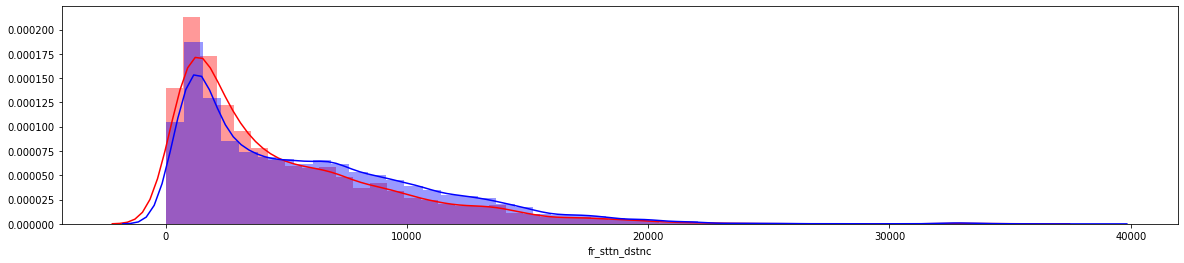

In [157]:
sns.distplot(train_[train.fr_yn=='Y']['fr_sttn_dstnc'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['fr_sttn_dstnc'], color='blue', label='fire_no')
## 119 안전센터와의 거리
### 거리 대비해서 가까워도 화재가 나긴하니 이부분도 고려를 좀 해봐야할듯?

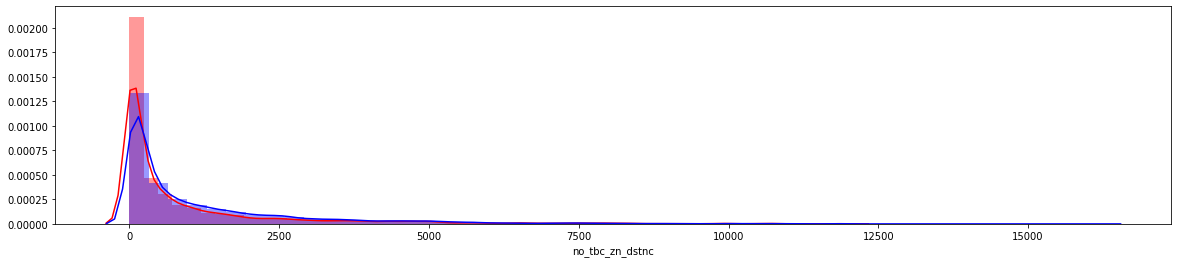

In [154]:
sns.distplot(train_[train.fr_yn=='Y']['no_tbc_zn_dstnc'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['no_tbc_zn_dstnc'], color='blue', label='fire_no')
## 금연구역과의 최소 거리
### 거리가 짧을수록 화재 위험도 높아지니 이거는 변수화 가능성 다분

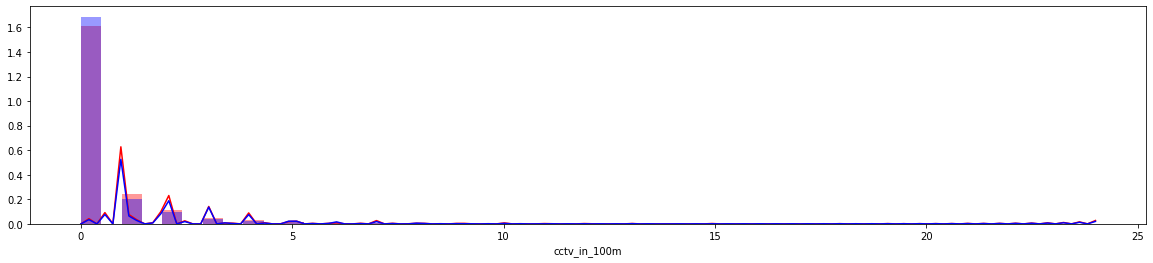

In [153]:
sns.distplot(train_[train.fr_yn=='Y']['cctv_in_100m'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['cctv_in_100m'], color='blue', label='fire_no')
## 100m 이내 공공 CCTV
### 큰 차이가 없어보이는데 고려해볼 필요는 있을듯

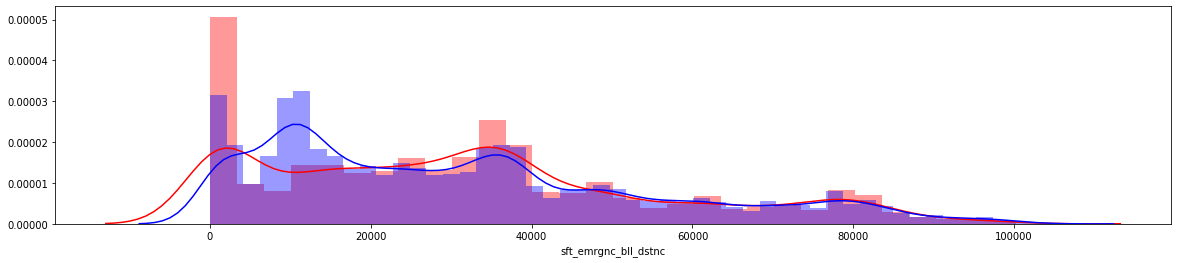

In [151]:
sns.distplot(train_[train.fr_yn=='Y']['sft_emrgnc_bll_dstnc'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['sft_emrgnc_bll_dstnc'], color='blue', label='fire_no')
## 안전 비상벨과의 최소 거리
### 대체적으로 비율 자체는 높게 나타나는데 거리상 의미가 다양해서 이부분은 좀더 고려해야할 듯.

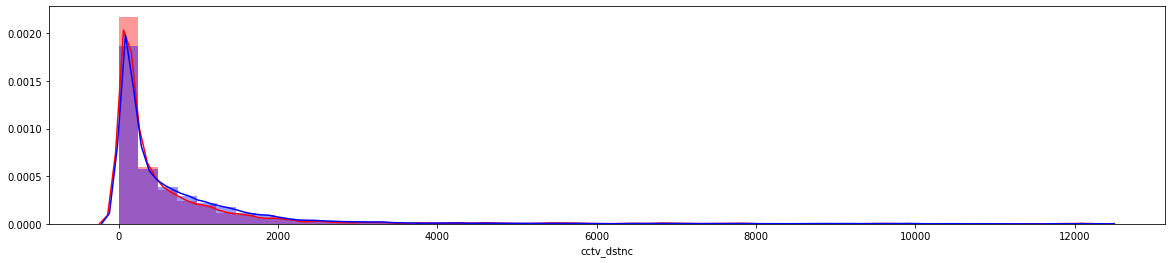

In [150]:
sns.distplot(train_[train.fr_yn=='Y']['cctv_dstnc'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['cctv_dstnc'], color='blue', label='fire_no')
## 공공 CCTV와의 최소 거리
### 화재난애들이랑 비율 자체는 비슷(거리가 비슷해서 그런가)
### 그래도 화재 난애들이 일단은 더 높으니 변수를 고민해봐야할 듯?

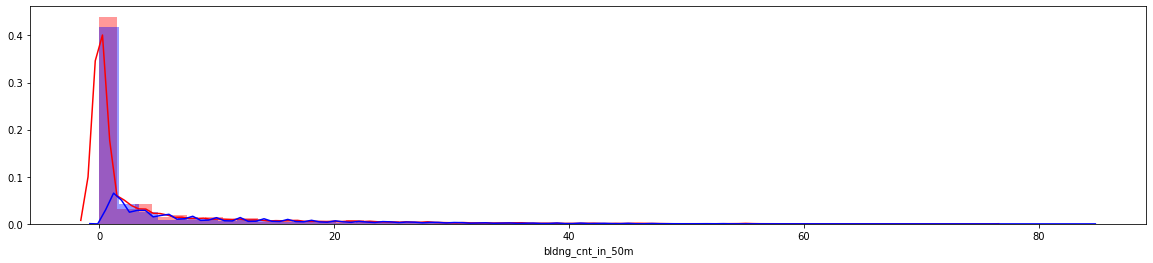

In [149]:
sns.distplot(train_[train.fr_yn=='Y']['bldng_cnt_in_50m'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['bldng_cnt_in_50m'], color='blue', label='fire_no')
## 반경 50M 이내의 건물 수
## 대다수가 반경에 건물이 없긴한대 화재가 높은 경우가 비율 자체는 월등히 높음.
### 즉 주위에 건물이 많으면 화재 위험도가 높다고 볼 수 있지않을까? 유의미한 변수 가능할듯

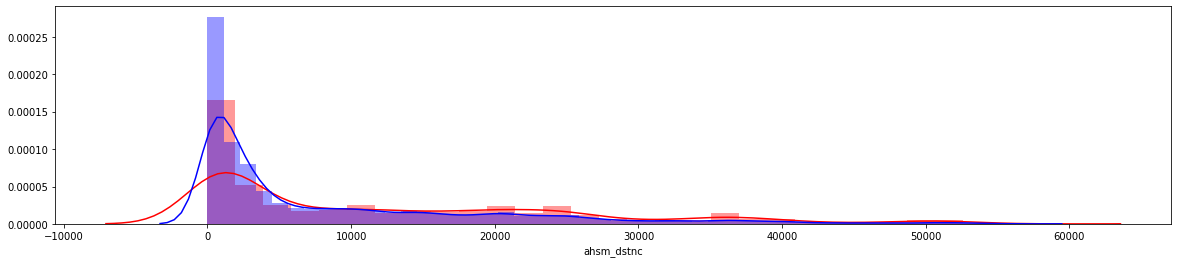

In [147]:
sns.distplot(train_[train.fr_yn=='Y']['ahsm_dstnc'], color='red', label='fire_yes')
sns.distplot(train_[train.fr_yn=='N']['ahsm_dstnc'], color='blue', label='fire_no')
## 	자동 심장 충격기와의 최소 거리
### 해당 변수는 불이 덜 나는 경우가 더 많은데 결측값을 확인해봐야될듯?
### 생각보다 유의미하지 않을수도??_화재와 직접적 영향 낮을듯

In [28]:
col_a = []
for i in range(34):
    a = str('bldng_us')+str(i)
    col_a.append(a)

In [29]:
col_a

['bldng_us0',
 'bldng_us1',
 'bldng_us2',
 'bldng_us3',
 'bldng_us4',
 'bldng_us5',
 'bldng_us6',
 'bldng_us7',
 'bldng_us8',
 'bldng_us9',
 'bldng_us10',
 'bldng_us11',
 'bldng_us12',
 'bldng_us13',
 'bldng_us14',
 'bldng_us15',
 'bldng_us16',
 'bldng_us17',
 'bldng_us18',
 'bldng_us19',
 'bldng_us20',
 'bldng_us21',
 'bldng_us22',
 'bldng_us23',
 'bldng_us24',
 'bldng_us25',
 'bldng_us26',
 'bldng_us27',
 'bldng_us28',
 'bldng_us29',
 'bldng_us30',
 'bldng_us31',
 'bldng_us32',
 'bldng_us33']